In [ ]:
%%shell

rm -rf /content/sample_data
mkdir configs datasets inference_model \
pretrained_model training test_images

In [ ]:
%%shell

git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 42314, done.
remote: Total 42314 (delta 0), reused 0 (delta 0), pack-reused 42314
Receiving objects: 100% (42314/42314), 549.50 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (28790/28790), done.


#### Install TensorFlow2 Object Detection Dependencies

In [ ]:
%%shell

cd /content/models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
     |████████████████████████████████| 8.3MB 6.2MB/s 
     |████████████████████████████████| 358kB 33.9MB/s 
     |████████████████████████████████| 849kB 33.1MB/s 
     |████████████████████████████████| 1.4MB 32.0MB/s 
     |████████████████████████████████| 63.8MB 46kB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 829kB 37.6MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
     |████████████████████████████████| 81kB 9.6MB/s 
     |████████████████████████████████| 153kB 41.1MB/s 
     |████████████████████████████████| 174kB 43.3MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 36.6MB 78kB/s 
     |████████████████████████████████| 1.1MB 39.9MB/s 
     |████████████████████████████████| 112kB 49.5MB/s 
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1550866 sha256=c50af88ef56c32a44d184e57ca4

#### Download Pre-Trained Model

In [ ]:
import os
import shutil
import urllib.request as urllib
import tarfile

# Downloading the Base Model
%cd /content

model = 'efficientdet_d0_coco17_tpu-32'

#selecting the model
model_file = model + '.tar.gz'

#creating the downlaod link for the model selected
pretrained_model_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'

#the distination folder where the model will be saved
fine_tune_dir = '/content/pretrained_model'
#checks if the model has already been downloaded
urllib.urlretrieve(pretrained_model_url + model_file, model_file)

tar = tarfile.open(model_file)
tar.extractall()
tar.close()

os.remove(model_file)
if (os.path.exists(fine_tune_dir)):
    shutil.rmtree(fine_tune_dir)
os.rename(model, fine_tune_dir)

/content


#### Configure the Training Pipeline

In [ ]:
pipeline_file = '/content/configs/ssd_efficientdet_d0_512x512_coco17_tpu-8.config'
model_dir = '/content/training/'
num_steps = 2000
num_eval_steps = 100

In [ ]:
%%writefile {pipeline_file}

# SSD with EfficientNet-b0 + BiFPN feature extractor,
# shared box predictor and focal loss (a.k.a EfficientDet-d0).
# See EfficientDet, Tan et al, https://arxiv.org/abs/1911.09070
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from an EfficientNet-b0 checkpoint.
#
# Train on TPU-8

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 1
    add_background_class: false
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
        anchor_scale: 4.0
        aspect_ratios: [1.0, 2.0, 0.5]
        scales_per_octave: 3
      }
    }
    image_resizer {
      keep_aspect_ratio_resizer {
        min_dimension: 512
        max_dimension: 512
        pad_to_max_dimension: true
        }
    }
    box_predictor {
      weight_shared_convolutional_box_predictor {
        depth: 64
        class_prediction_bias_init: -4.6
        conv_hyperparams {
          force_use_bias: true
          activation: SWISH
          regularizer {
            l2_regularizer {
              weight: 0.00004
            }
          }
          initializer {
            random_normal_initializer {
              stddev: 0.01
              mean: 0.0
            }
          }
          batch_norm {
            scale: true
            decay: 0.99
            epsilon: 0.001
          }
        }
        num_layers_before_predictor: 3
        kernel_size: 3
        use_depthwise: true
      }
    }
    feature_extractor {
      type: 'ssd_efficientnet-b0_bifpn_keras'
      bifpn {
        min_level: 3
        max_level: 7
        num_iterations: 3
        num_filters: 64
      }
      conv_hyperparams {
        force_use_bias: true
        activation: SWISH
        regularizer {
          l2_regularizer {
            weight: 0.00004
          }
        }
        initializer {
          truncated_normal_initializer {
            stddev: 0.03
            mean: 0.0
          }
        }
        batch_norm {
          scale: true,
          decay: 0.99,
          epsilon: 0.001,
        }
      }
    }
    loss {
      classification_loss {
        weighted_sigmoid_focal {
          alpha: 0.25
          gamma: 1.5
        }
      }
      localization_loss {
        weighted_smooth_l1 {
        }
      }
      classification_weight: 1.0
      localization_weight: 1.0
    }
    normalize_loss_by_num_matches: true
    normalize_loc_loss_by_codesize: true
    post_processing {
      batch_non_max_suppression {
        score_threshold: 1e-8
        iou_threshold: 0.5
        max_detections_per_class: 100
        max_total_detections: 100
      }
      score_converter: SIGMOID
    }
  }
}

train_config: {
  fine_tune_checkpoint: '/content/pretrained_model/checkpoint/ckpt-0'
  fine_tune_checkpoint_version: V2
  fine_tune_checkpoint_type: "detection"
  batch_size: 4
  sync_replicas: true
  startup_delay_steps: 0
  replicas_to_aggregate: 8
  use_bfloat16: true
  num_steps: 40000
  data_augmentation_options {
    random_horizontal_flip {
    }
  }
  data_augmentation_options {
    random_scale_crop_and_pad_to_square {
      output_size: 512
      scale_min: 0.1
      scale_max: 2.0
    }
  }
  optimizer {
    momentum_optimizer: {
      learning_rate: {
        cosine_decay_learning_rate {
          learning_rate_base: 8e-2
          total_steps: 300000
          warmup_learning_rate: .001
          warmup_steps: 2500
        }
      }
      momentum_optimizer_value: 0.9
    }
    use_moving_average: false
  }
  max_number_of_boxes: 100
  unpad_groundtruth_tensors: false
}

train_input_reader: {
  label_map_path: "/content/datasets/label_map.pbtxt"
  tf_record_input_reader {
    input_path: "/content/datasets/train (1).tfrecord"
  }
}

eval_config: {
  metrics_set: "coco_detection_metrics"
  use_moving_averages: false
  batch_size: 4;
}

eval_input_reader: {
  label_map_path: "/content/datasets/label_map.pbtxt"
  shuffle: false
  num_epochs: 1
  tf_record_input_reader {
    input_path: "/content/datasets/train (1).tfrecord"
  }
}

Writing /content/configs/ssd_efficientdet_d0_512x512_coco17_tpu-8.config


#### Train Custom TF2 Object Detector

In [ ]:
%%shell

python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path=/content/configs/ssd_efficientdet_d0_512x512_coco17_tpu-8.config \
    --model_dir=/content/training/ \
    --alsologtostderr \
    --num_train_steps=1000 \
    --sample_1_of_n_eval_examples=1 \
    --num_eval_steps=100

2020-08-24 13:57:35.850263: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-24 13:57:38.503469: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-24 13:57:38.554532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-24 13:57:38.555342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-08-24 13:57:38.555406: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-24 13:57:38.821028: I tensorflow/stream_executor/platform/defa

#### Exporting a Trained Inference Graph

In [ ]:
train_ckpt_path = '/content/training/'
output_directory = '/content/inference_model'


!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {train_ckpt_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

2020-08-24 14:11:47.976028: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-24 14:11:50.298795: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-08-24 14:11:50.319005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-08-24 14:11:50.319811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla K80 computeCapability: 3.7
coreClock: 0.8235GHz coreCount: 13 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 223.96GiB/s
2020-08-24 14:11:50.319864: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-08-24 14:11:50.322202: I tensorflow/stream_executor/platform/defa

#### Download Saved Model

In [ ]:
!zip -r /content/inference_model.zip /content/inference_model
from google.colab import files
files.download("/content/inference_model.zip")

  adding: content/inference_model/ (stored 0%)
  adding: content/inference_model/saved_model/ (stored 0%)
  adding: content/inference_model/saved_model/variables/ (stored 0%)
  adding: content/inference_model/saved_model/variables/variables.index (deflated 77%)
  adding: content/inference_model/saved_model/variables/variables.data-00000-of-00001 (deflated 36%)
  adding: content/inference_model/saved_model/saved_model.pb (deflated 93%)
  adding: content/inference_model/saved_model/assets/ (stored 0%)
  adding: content/inference_model/pipeline.config (deflated 68%)
  adding: content/inference_model/checkpoint/ (stored 0%)
  adding: content/inference_model/checkpoint/checkpoint (deflated 41%)
  adding: content/inference_model/checkpoint/ckpt-0.data-00000-of-00001 (deflated 36%)
  adding: content/inference_model/checkpoint/ckpt-0.index (deflated 80%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Run Inference from Saved Model

In [ ]:
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [ ]:
# Load the Label Map
category_index = {
    1: {'id': 1, 'name': 'Apple'}
}

In [ ]:
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/content/inference_model/saved_model/')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 30.853220462799072s


Elapsed time: 1.2880508104960124 second per image


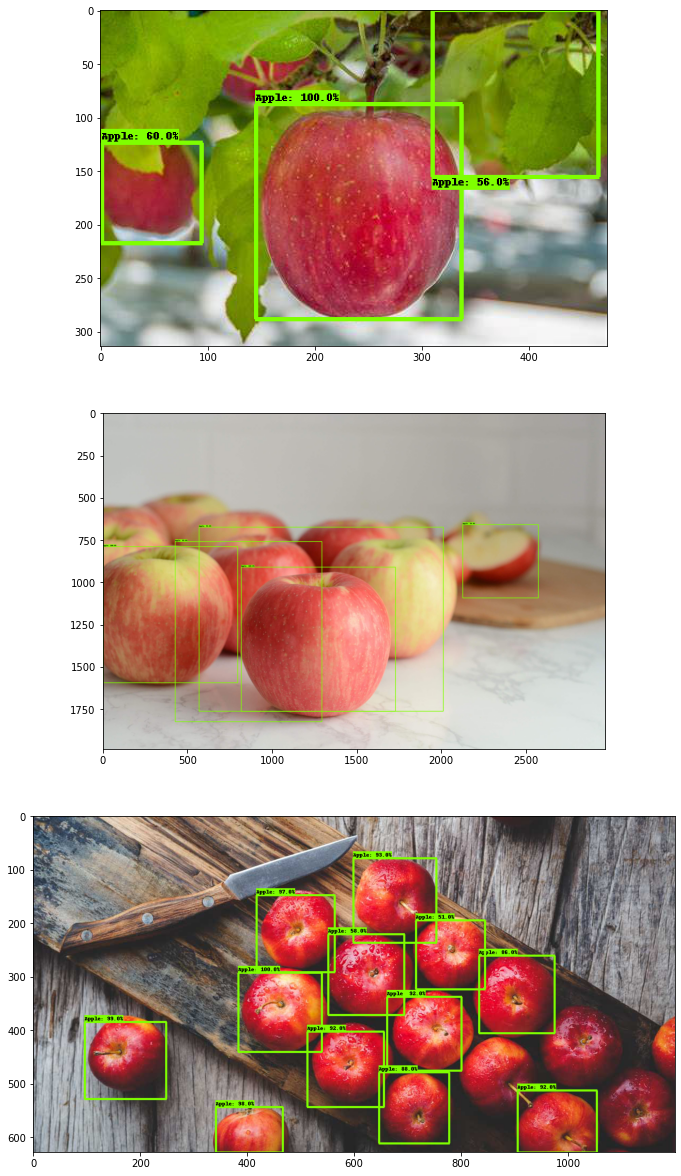

In [ ]:
import time

image_dir = '/content/test_images'

elapsed = []
for i in range(3):
  image_path = os.path.join(image_dir, 'apple' + str(i + 1) + '.jpeg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.50,
        agnostic_mode=False)
  plt.subplot(3, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')